In [15]:
# 块一：环境设置与数据加载
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
import os

# (1) 路径与参数设置
DATA_DIR = '../../Data/0'
RESULT_DIR = './Result'
IMAGE_DIR = os.path.join(RESULT_DIR, 'Images')

# (2) 绘图字体与风格设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid", {"font.sans-serif": ['SimHei', 'Arial']})

# (3) 创建输出文件夹
os.makedirs(IMAGE_DIR, exist_ok=True)

# (4) 加载数据
file_path = os.path.join(DATA_DIR, '男胎_预处理后数据.csv')
male_df = pd.read_csv(file_path)

# 验证数据维度
print("数据加载完成，维度:", male_df.shape)

数据加载完成，维度: (1021, 34)


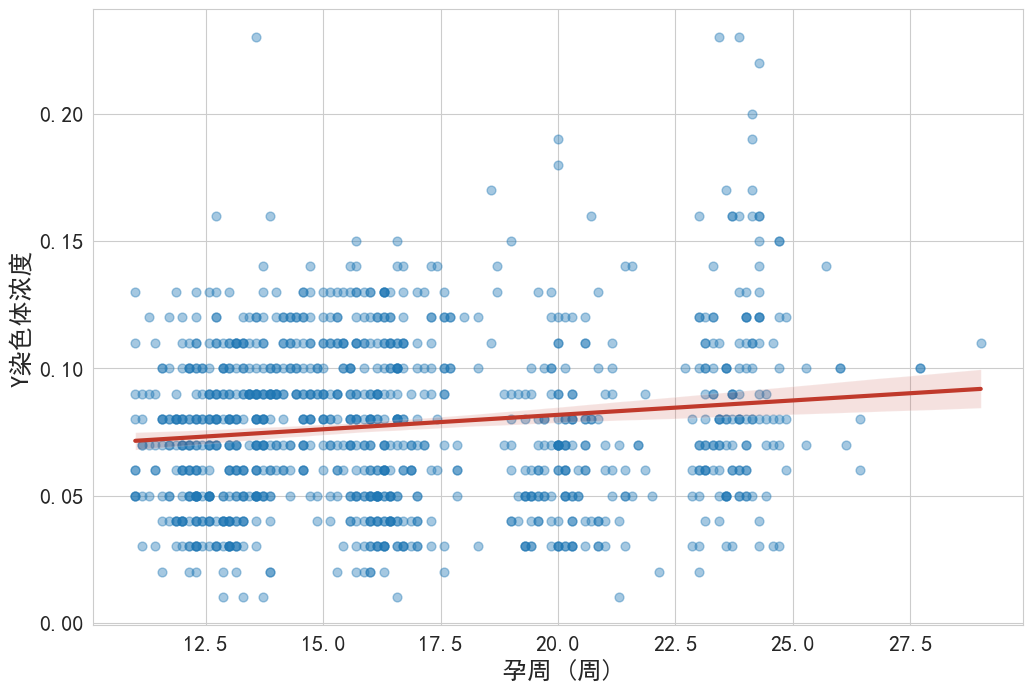

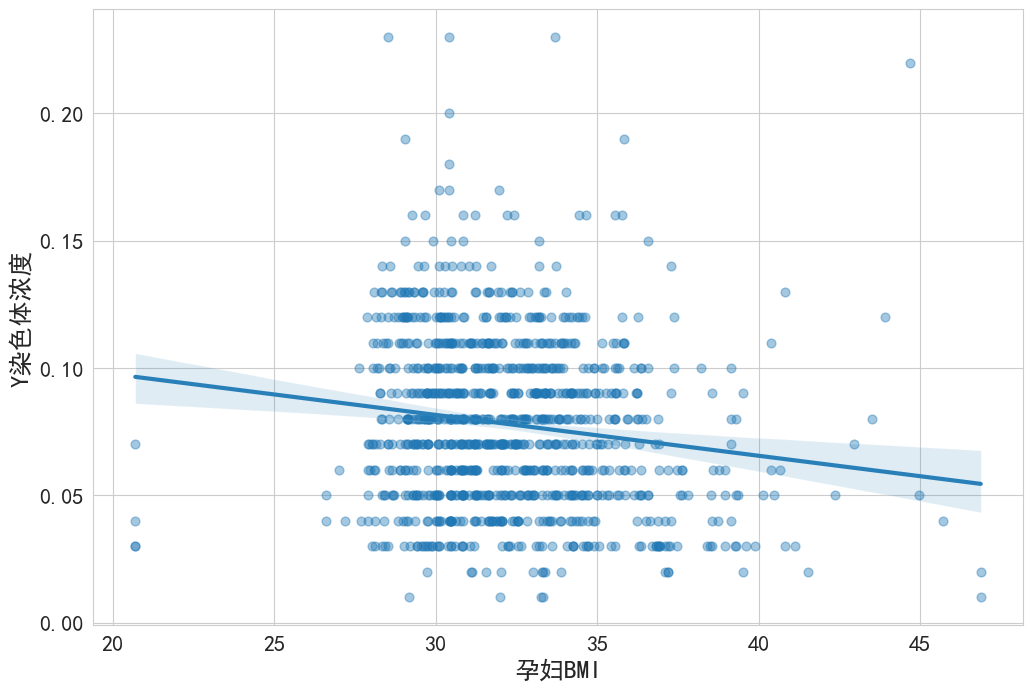

--- 皮尔逊相关系数矩阵 ---
          Y染色体浓度        孕周     孕妇BMI        年龄
Y染色体浓度  1.000000  0.134612 -0.142771 -0.101955
孕周      0.134612  1.000000  0.142475 -0.003778
孕妇BMI  -0.142771  0.142475  1.000000  0.002481
年龄     -0.101955 -0.003778  0.002481  1.000000


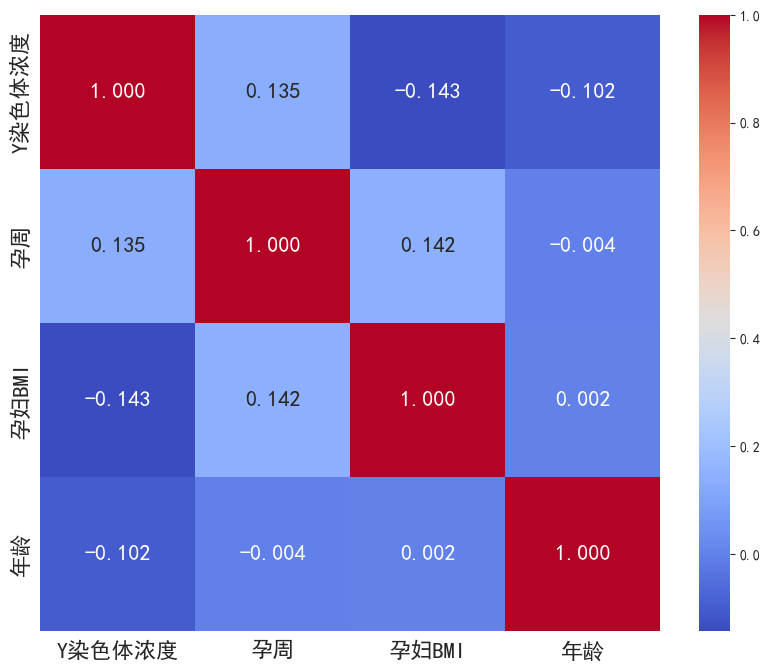

In [16]:
# 块二：数据准备与定性分析 (可视化 & 相关性)

# (1) 准备用于分析的DataFrame，选取核心变量并去除缺失值
core_vars = ['Y染色体浓度', '孕周', '孕妇BMI', '年龄']
analysis_df = male_df[core_vars].dropna()

# (2) 可视化探索
# 散点图 1: Y染色体浓度 vs 孕周
plt.figure(figsize=(12, 8))
sns.regplot(data=analysis_df, x='孕周', y='Y染色体浓度',
            scatter_kws={'alpha': 0.4, 's': 40},
            line_kws={'color': '#c0392b', 'linewidth': 3})
plt.xlabel('孕周 (周)', fontsize=18)
plt.ylabel('Y染色体浓度', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(os.path.join(IMAGE_DIR, 'Y染色体浓度与孕周的散点回归图.png'), dpi=300, bbox_inches='tight')
plt.show()

# 散点图 2: Y染色体浓度 vs 孕妇BMI
plt.figure(figsize=(12, 8))
sns.regplot(data=analysis_df, x='孕妇BMI', y='Y染色体浓度',
            scatter_kws={'alpha': 0.4, 's': 40},
            line_kws={'color': '#2980b9', 'linewidth': 3})
plt.xlabel('孕妇BMI', fontsize=18)
plt.ylabel('Y染色体浓度', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(os.path.join(IMAGE_DIR, 'Y染色体浓度与孕妇BMI的散点回归图.png'), dpi=300, bbox_inches='tight')
plt.show()

# (3) 相关性分析
pearson_corr = analysis_df.corr(method='pearson')
print("--- 皮尔逊相关系数矩阵 ---")
print(pearson_corr)
pearson_corr.to_csv(os.path.join(RESULT_DIR, '皮尔逊相关系数矩阵.csv'), encoding='utf-8-sig')

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".3f", annot_kws={"size": 16})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(os.path.join(IMAGE_DIR, '核心变量皮尔逊相关性热力图.png'), dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# 块三：定量计算 - 初步模型比较

# (1) 准备模型数据 (过滤Y染色体浓度为非正数的数据)
model_df = analysis_df[analysis_df['Y染色体浓度'] > 0].copy()

# (2) 定义并拟合四种候选模型
model_linear = smf.ols('Y染色体浓度 ~ 孕周 + 孕妇BMI', data=model_df).fit()
model_poly = smf.ols('Y染色体浓度 ~ 孕周 + I(孕周**2) + 孕妇BMI', data=model_df).fit()
model_log = smf.ols('Y染色体浓度 ~ np.log(孕周) + 孕妇BMI', data=model_df).fit()
model_exp = smf.ols('np.log(Y染色体浓度) ~ 孕周 + 孕妇BMI', data=model_df).fit()

# (3) 评估模型并选择最优
y_true = model_df['Y染色体浓度']
y_pred_exp = np.exp(model_exp.predict(model_df))
r2_comparable_exp = r2_score(y_true, y_pred_exp)

model_comparison = pd.DataFrame({
    '模型类型': ['多元线性回归', '多项式回归', '对数回归', '指数回归'],
    '模型公式': ['Y ~ W + B', 'Y ~ W + W^2 + B', 'Y ~ ln(W) + B', 'ln(Y) ~ W + B'],
    '判定系数 (R²)': [model_linear.rsquared, model_poly.rsquared, model_log.rsquared, r2_comparable_exp]
})
model_comparison = model_comparison.sort_values(by='判定系数 (R²)', ascending=False).reset_index(drop=True)

# (4) 打印结果并保存
print("--- 各候选模型评估对比 ---")
print(model_comparison)
model_comparison.to_csv(os.path.join(RESULT_DIR, '各回归模型评估对比.csv'), index=False, encoding='utf-8-sig')

--- 各候选模型评估对比 ---
     模型类型             模型公式  判定系数 (R²)
0   多项式回归  Y ~ W + W^2 + B   0.046868
1  多元线性回归        Y ~ W + B   0.044892
2    对数回归    Y ~ ln(W) + B   0.043841
3    指数回归    ln(Y) ~ W + B  -0.007398


In [18]:
# 块四：最终模型优化 (向后剔除法)

# (1) 准备包含所有潜在变量的、最完整的数据集
all_vars = [
    'Y染色体浓度', '孕周', '孕妇BMI', '年龄', '生产次数',
    '怀孕次数_1', '怀孕次数_2', '怀孕次数_≥3'
]
model_df_full = male_df[all_vars].dropna()
model_df_full = model_df_full[model_df_full['Y染色体浓度'] > 0].copy()
model_df_full.rename(columns={'怀孕次数_≥3': '怀孕次数_gte3'}, inplace=True)

# (2) 构建初始的“大而全”的综合模型
full_formula = (
    'Y染色体浓度 ~ 孕周 + I(孕周**2) + 孕妇BMI + 年龄 + 生产次数 + '
    '怀孕次数_2 + 怀孕次数_gte3 + 孕周 * 孕妇BMI'
)
model_full = smf.ols(full_formula, data=model_df_full).fit()
print("--- 初始综合模型 ---")
print(model_full.summary())

# (3) 执行向后剔除法，移除p值最高的变量(怀孕次数_gte3, p=0.638)
formula_step2 = (
    'Y染色体浓度 ~ 孕周 + I(孕周**2) + 孕妇BMI + 年龄 + 生产次数 + '
    '怀孕次数_2 + 孕周 * 孕妇BMI'
)
model_step2 = smf.ols(formula_step2, data=model_df_full).fit()

# (4) 继续剔除p值最高的变量(I(孕周**2), p=0.241)
formula_step3 = (
    'Y染色体浓度 ~ 孕周 + 孕妇BMI + 年龄 + 生产次数 + '
    '怀孕次数_2 + 孕周 * 孕妇BMI'
)
model_step3 = smf.ols(formula_step3, data=model_df_full).fit()
# 在此模型中，所有变量的p值均小于0.1，因此我们停止剔除

# (5) 最终优化后的模型
final_model = model_step3
print("\n" + "="*80 + "\n")
print("--- 最终优化模型 ---")
final_summary = final_model.summary()
print(final_summary)

# (6) 保存最终模型的结果
final_summary_df = pd.read_html(final_summary.tables[1].as_html(), header=0, index_col=0)[0]
final_summary_path = os.path.join(RESULT_DIR, '最终优化模型显著性检验结果.csv')
final_summary_df.to_csv(final_summary_path, encoding='utf-8-sig')
print(f"\n最终优化模型的详细结果已保存至: '{final_summary_path}'")

--- 初始综合模型 ---
                            OLS Regression Results                            
Dep. Variable:                 Y染色体浓度   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     9.797
Date:                Fri, 05 Sep 2025   Prob (F-statistic):           3.56e-13
Time:                        11:03:28   Log-Likelihood:                 2051.4
No. Observations:                1020   AIC:                            -4085.
Df Residuals:                    1011   BIC:                            -4040.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0

C:\Users\86185\AppData\Local\Temp\ipykernel_34928\1841277243.py:44: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  final_summary_df = pd.read_html(final_summary.tables[1].as_html(), header=0, index_col=0)[0]
